In [1]:
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt

def prepare_data(df):
    module_area = (df['total_area'] * (1 - (df['dead_area'] / 100)) )[0]
    module_area = module_area.round(0)
    module_area

    df["time[s]"] = df["time[ms]"] / 1000
    df["total_wire"] = df["total_wire"] / 10**5
    df = df.round(3)

    def compute_dead_area(col):
        return (100 * (1 - (module_area  / col))).round(2)

    group = ['floorplan', "alpha", "cluster_growing", "recursive_bisection"]
    agg_f = ['mean','min', 'max']
    values = ["time[s]", "total_wire", "total_area"]
    df2 = df.groupby(group)[values].agg(agg_f).reset_index().round(3)
    compute_dead_area(df2["total_area"]["min"])

    df2["dead_area_avg"] = compute_dead_area(df2["total_area"]["mean"])
    df2["dead_area_min"] = compute_dead_area(df2["total_area"]["min"])
    df2["dead_area_max"] = compute_dead_area(df2["total_area"]["max"])
    return df2


floorplan alpha cluster_growing recursive_bisection  time[s]           \
                                                               mean      min   
0  sequence_pair   0.5           False               False  172.599  171.632   
1  sequence_pair   0.5           False                True  171.185  168.280   
2  sequence_pair   0.5            True                True  170.355  169.488   
3   slicing_tree   0.5           False               False  248.357  223.123   
4   slicing_tree   0.5           False                True  239.675  209.250   
5   slicing_tree   0.5            True                True  260.454  245.438   

           total_wire               total_area                 dead_area_avg  \
       max       mean    min    max       mean     min     max                 
0  173.095      3.787  3.620  3.858   348264.4  327546  394788         21.56   
1  174.992      4.266  4.033  4.745   332571.8  309876  372165         17.86   
2  171.420      4.454  4.292  4.643   314550.4  310674  319780         13.15   
3  261.517      5.417  5.271  5.511   403619.4  377478  438894         32.32   
4  261.129      5.468  5.340  5.595   357495.4  342422  371700         23.59   
5  271.205      5.045  4.887  5.236   339776.6  314717  371371         19.60   

  dead_area_min dead_area_max  
                               
0         16.60         30.81  
1         11.84         26.60  
2         12.07         14.57  
3         27.63         37.76  
4         20.22         26.51  
5         13.20         26.44

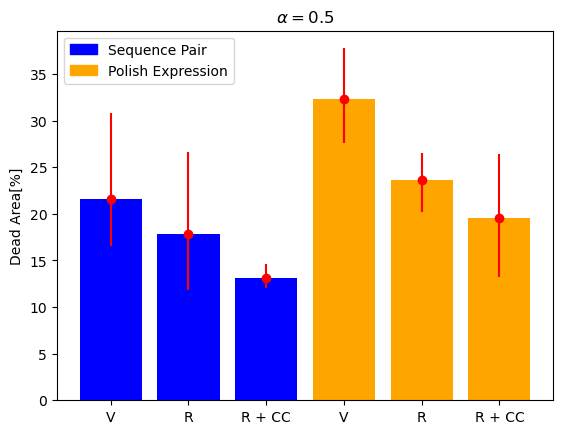

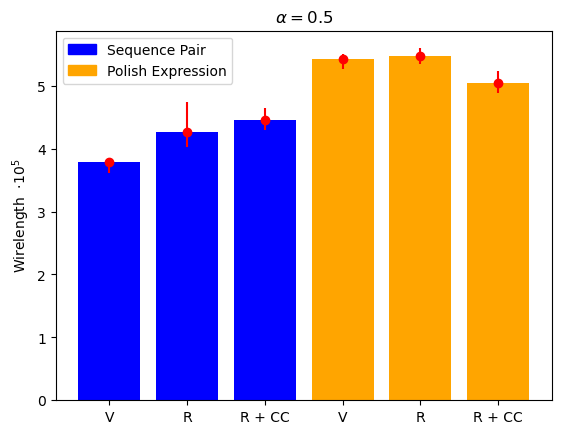

In [2]:
def make_bar_plot(y, e, y_label, file="output.png"):
    x = list(range(len(y)))
    width = 0.8
    my_colors = ["blue"] * 3 + ["orange"] * 3
    names = ["V", "R", "R + CC"] * 2
    SP = mpatches.Patch(color='blue', label='Sequence Pair')
    PE = mpatches.Patch(color='orange', label='Polish Expression')

    fig, ax = plt.subplots()
    ax.bar(x, y, width, color=my_colors)
    ax.errorbar(x, y, yerr=e, fmt="o", color="red")
    ax.set_ylabel(y_label)
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_title(r"$\alpha = 0.5$")
    ax.legend(handles=[SP, PE], loc=2)
    fig.savefig(file)

file = "compare_init.csv"
df = pd.read_csv(file)
df2 = prepare_data(df)

# plot1
y = df2["dead_area_avg"]
e = np.array([df2["dead_area_avg"] - df2["dead_area_min"], df2["dead_area_max"] - df2["dead_area_avg"]])
y_label = "Dead Area[%]"
file = "compare_deadarea.png"
make_bar_plot(y, e, y_label, file)

# plot2
y = df2["total_wire"]["mean"]
e = np.array([df2["total_wire"]["mean"] - df2["total_wire"]["min"], df2["total_wire"]["max"] - df2["total_wire"]["mean"]])
y_label = "Wirelength  $\cdot 10^5$"
file = "compare_wire.png"
make_bar_plot(y, e, y_label, file)

df2

,floorplan,time[s]
0,sequence_pair,170.292
1,slicing_tree,253.436


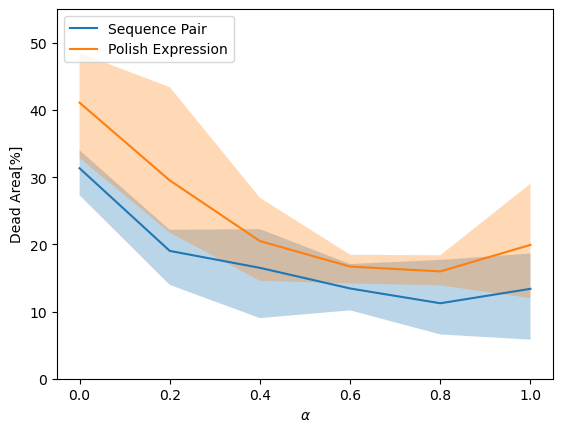

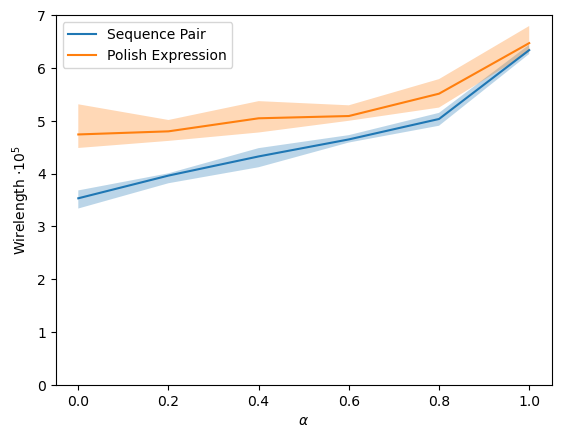

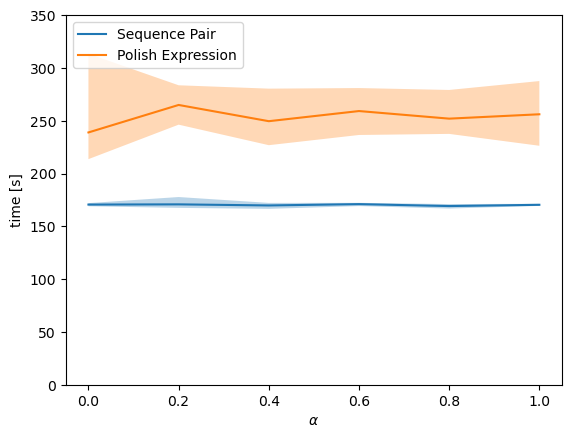

In [3]:
# file = "alphas_test.csv"
file = "alphas.csv"
df = pd.read_csv(file)
df2 = prepare_data(df)

df_pe = df2[df2["floorplan"] == "slicing_tree"]
df_sp = df2[df2["floorplan"] == "sequence_pair"]
x = df2["alpha"].unique()

def make_plot(y1, e1, f1, y2, e2, f2, y_label, ymin, ymax, file="output.png"):
    fig, ax = plt.subplots()
    alpha = 0.3
    ax.plot(x, y1, label="Sequence Pair")
    ax.fill_between(x, e1, f1, alpha=alpha)
    ax.plot(x, y2, label="Polish Expression")
    ax.fill_between(x, e2, f2, alpha=alpha)
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(y_label)
    ax.set_xticks(x)
    ax.legend(loc="upper left")
    ax.set_ylim([ymin, ymax])
    fig.savefig(file)


# avg time
df3 = df.groupby("floorplan")["time[s]"].agg("mean").reset_index().round(3)
display(df3)

# plot3
y1 = df_sp["dead_area_avg"]
e1 = df_sp["dead_area_min"]
f1 = df_sp["dead_area_max"]

y2 = df_pe["dead_area_avg"]
e2 = df_pe["dead_area_min"]
f2 = df_pe["dead_area_max"]

y_label = "Dead Area[%]"
ymin = 0
ymax = 55
file = "alphas_deadarea.png"
make_plot(y1, e1, f1, y2, e2, f2, y_label, ymin, ymax, file)

# plot4
y1 = df_sp["total_wire"]["mean"]
e1 = df_sp["total_wire"]["min"]
f1 = df_sp["total_wire"]["max"]

y2 = df_pe["total_wire"]["mean"]
e2 = df_pe["total_wire"]["min"]
f2 = df_pe["total_wire"]["max"]

y_label = "Wirelength $\cdot 10^5$"
ymin = 0
ymax = 7
file = "alphas_wire.png"
make_plot(y1, e1, f1, y2, e2, f2, y_label, ymin, ymax, file)

# plot5
y1 = df_sp["time[s]"]["mean"]
e1 = df_sp["time[s]"]["min"]
f1 = df_sp["time[s]"]["max"]

y2 = df_pe["time[s]"]["mean"]
e2 = df_pe["time[s]"]["min"]
f2 = df_pe["time[s]"]["max"]

y_label = "time [s]"
ymin = 0
ymax = 350
file = "alphas_time.png"
make_plot(y1, e1, f1, y2, e2, f2, y_label, ymin, ymax, file)
